In [78]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from scipy import interpolate
from scipy import integrate

# Load HondaGaisser's initial atmospheric numu fluxes from pions and kaons
# These are from the IC86SterileNeutrinoDataRelease
# These are the initial fluxes, i.e. before propagation through earth
# IC86SterileNeutrinoDataRelease/atmospheric_flux/initial/

pi_dat_file = "initial_pion_atmopheric_HondaGaisser.dat"
k_dat_file = "initial_kaon_atmopheric_HondaGaisser.dat"

pi_cos_long, pi_E_long, pi_nu_mu_unshaped, pi_nu_mu_bar_unshaped = np.loadtxt(pi_dat_file, unpack=True)
k_cos_long, k_E_long, k_nu_mu_unshaped, k_nu_mu_bar_unshaped = np.loadtxt(k_dat_file, unpack=True)

# Remove repeating values for cosZ and energy coordinates

cos = pi_cos_long[0:6000:150]
E = pi_E_long[:150]

# Reshape and transpose the flux 2-d arays so that they match the energy and cosZ coordinate arrays

pi_nu_mu = pi_nu_mu_unshaped.reshape(40,150).transpose()
pi_nu_mu_bar = pi_nu_mu_bar_unshaped.reshape(40,150).transpose()

k_nu_mu = k_nu_mu_unshaped.reshape(40,150).transpose()
k_nu_mu_bar = k_nu_mu_bar_unshaped.reshape(40,150).transpose()

In [79]:
# Make a copy to change naming convention of energy and coordinate arrays

x = E
y = cos

# Build 2D array of x and y values
# Uppercase corresponds to 2D arrays
# Lowercase corresponds to 1D arrays

X = np.zeros((len(x),len(y)))
Y = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        X[i][j] = x[i]
        Y[i][j] = y[j]
        
# Change naming convention of fluxes

Z_pi = pi_nu_mu
Z_k = k_nu_mu
Z_pi_b = pi_nu_mu_bar
Z_k_b = k_nu_mu_bar

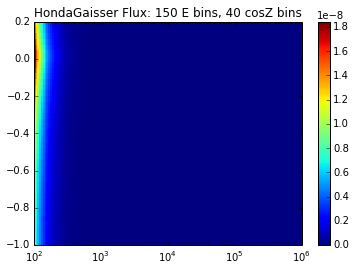

In [80]:
# Plot initial flux
# The plot is a little bit wrong. It uses coordinates as bin edges

plt.figure()
plt.pcolor(X,Y,Z_pi)
plt.xscale('log')
plt.colorbar()
plt.title("HondaGaisser Flux: 150 E bins, 40 cosZ bins")
plt.show()

In [81]:
# Build a spline by interpolating the flux

s_pi = interpolate.RectBivariateSpline(x,y,Z_pi)
s_k = interpolate.RectBivariateSpline(x,y,Z_k)
s_pi_b = interpolate.RectBivariateSpline(x,y,Z_pi_b)
s_k_b = interpolate.RectBivariateSpline(x,y,Z_k_b)

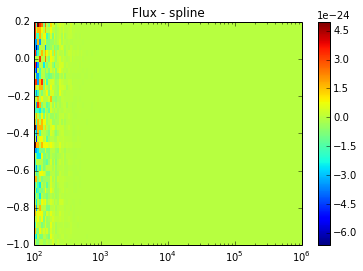

In [82]:
# Sanity check
# Evaluate the spline at the original coordinates

Z_sanity = s_pi(x,y)
plt.figure()
plt.pcolor(X,Y,Z_pi-Z_sanity)
plt.xscale('log')
plt.colorbar()
plt.title("Flux - spline")
plt.show()

# The plot is a little bit wrong. It uses coordinates as bin edges
# Differences are on the order of 10**-24, which is fine

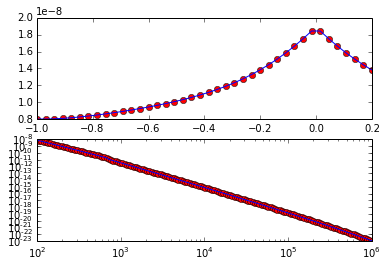

In [83]:
# Sanity check
# Compare the spline function to the original flux values, for a given energy, and for a given cosZ

plt.figure(1)
plt.subplot(211)
plt.plot(y,Z_pi[0,:],'ro')
plt.plot(y,s_pi(x[0],y)[0])

# The line below calls Chris's flux before it is loaded
#plt.plot(ynew[:-1],Chris_avg_flux[0,:],'bo')

plt.subplot(212)
plt.plot(x,Z_pi[:,0],'ro')
plt.plot(x,s_pi(x,y[0])[:,0])

# The line below calls Chris's flux before it is loaded
#plt.plot(xnew[:-1],Chris_avg_flux[:,0],'bo')

plt.xscale('log')
plt.yscale('log')
plt.show()

In [84]:
# Get new bin edges from Chris Weaver's flux file

convFile = h5py.File("conventional_flux.h5","r")

bin_edges_0 = convFile['/nu_mu/bin_edges_0']
bin_edges_1 = convFile['/nu_mu/bin_edges_1']

xnew = bin_edges_0[:]
ynew = bin_edges_1[:]

XNEW = np.zeros((len(xnew),len(ynew)))
YNEW = np.zeros((len(xnew),len(ynew)))
for i in range(len(xnew)):
    for j in range(len(ynew)):
        XNEW[i][j] = xnew[i]
        YNEW[i][j] = ynew[j]

In [85]:
# Initalize empty array for the bin-averaged, and bin-integrated fluxes

avg_flux_pi = np.zeros((len(xnew)-1,len(ynew)-1))
avg_flux_k = np.zeros((len(xnew)-1,len(ynew)-1))
avg_flux_pi_b = np.zeros((len(xnew)-1,len(ynew)-1))
avg_flux_k_b = np.zeros((len(xnew)-1,len(ynew)-1))

int_flux_pi = np.zeros((len(xnew)-1,len(ynew)-1))
int_flux_k = np.zeros((len(xnew)-1,len(ynew)-1))
int_flux_pi_b = np.zeros((len(xnew)-1,len(ynew)-1))
int_flux_k_b = np.zeros((len(xnew)-1,len(ynew)-1))

In [86]:
# For each energy and cosZ bin, 
# integate the spline across the 2-D bin, 
# then divide by the phase space to get the bin-averaged flux
# Set the value of the bin-averaged flux!
# Set the value of the bin-integrated (and azimuthal-integrated) flux

for j in range(len(ynew)-1):
    for i in range(len(xnew)-1):
        i1, e1 = integrate.dblquad(lambda vy, vx: s_pi(vy,vx), ynew[j], ynew[j+1], 
                                        lambda vy: xnew[i], lambda vy: xnew[i+1])
        i2, e2 = integrate.dblquad(lambda vy, vx: s_k(vy,vx), ynew[j], ynew[j+1], 
                                        lambda vy: xnew[i], lambda vy: xnew[i+1])
        i3, e3 = integrate.dblquad(lambda vy, vx: s_pi_b(vy,vx), ynew[j], ynew[j+1], 
                                        lambda vy: xnew[i], lambda vy: xnew[i+1])
        i4, e4 = integrate.dblquad(lambda vy, vx: s_k_b(vy,vx), ynew[j], ynew[j+1], 
                                        lambda vy: xnew[i], lambda vy: xnew[i+1])

        a1 = i1 / ((xnew[i+1]-xnew[i])*(ynew[j+1]-ynew[j]))
        a2 = i2 / ((xnew[i+1]-xnew[i])*(ynew[j+1]-ynew[j]))
        a3 = i3 / ((xnew[i+1]-xnew[i])*(ynew[j+1]-ynew[j]))
        a4 = i4 / ((xnew[i+1]-xnew[i])*(ynew[j+1]-ynew[j]))
       
        avg_flux_pi[i][j]   = a1
        avg_flux_k[i][j]    = a2
        avg_flux_pi_b[i][j] = a3
        avg_flux_k_b[i][j]  = a4
        
        int_flux_pi[i][j]   = i1*2*np.pi
        int_flux_k[i][j]    = i2*2*np.pi
        int_flux_pi_b[i][j] = i3*2*np.pi
        int_flux_k_b[i][j]  = i4*2*np.pi
        

In [87]:
# For all energies above the highest energy of the original file, 
# set flux to zero
# because we don't have any information on the flux there
# and we don't want to get confused in the future

Emax = E.max()
cutoff_index = np.argmax(xnew>=Emax) -1

for j in range(len(ynew)-1):
    for i in range(len(xnew)-1):
        if i > cutoff_index:
            avg_flux_pi[i][j]   = 0
            avg_flux_k[i][j]    = 0
            avg_flux_pi_b[i][j] = 0
            avg_flux_k_b[i][j]  = 0
            int_flux_pi[i][j]   = 0
            int_flux_k[i][j]    = 0
            int_flux_pi_b[i][j] = 0
            int_flux_k_b[i][j]  = 0

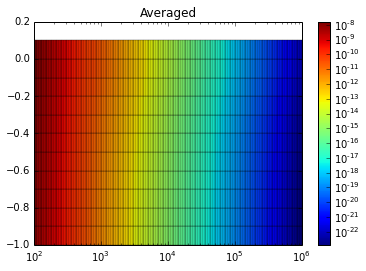

In [88]:
# Plot the bin-averaged flux

plt.figure()
plt.pcolor(XNEW,YNEW,avg_flux_pi, norm = colors.LogNorm(), edgecolors='k', linewidths=0.3)
#plt.pcolor(XNEW,YNEW,avg_flux_pi))
plt.xscale('log')
plt.xlim(xmax=1000000)
plt.colorbar()
plt.title("Averaged")
plt.show()

In [89]:
# Check that the bin-averaged flux is reasonable
# Perform a simple averaging of coordinates to get coordinate values in the middle of each bin

xavg = np.zeros(len(xnew)-1)
yavg = np.zeros(len(ynew)-1)

for i in np.arange(len(xnew)-1):
    xavg[i] = (xnew[i]+xnew[i+1])/2
    
for i in np.arange(len(ynew)-1):
    yavg[i] = (ynew[i]+ynew[i+1])/2

In [90]:
# Evaluate the spline at these averaged coordinates

Z_AVG = s_pi(xavg,yavg)

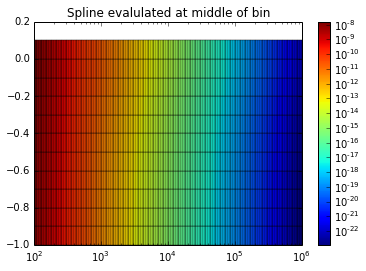

In [91]:
# Plot the spline evaluated at the middle of each bin

plt.figure()
plt.pcolor(XNEW,YNEW,Z_AVG, 
           norm = colors.LogNorm(), edgecolors='k', linewidths=0.4)
plt.xscale('log')
plt.xlim(xmax=1000000)
plt.colorbar()
plt.title("Spline evalulated at middle of bin")
plt.show()

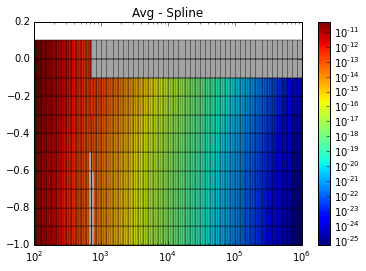

In [92]:
# Sanity check
# Plot the difference between the bin-averaged flux and the spline evaluated at the middle of each bin

plt.figure()
plt.pcolor(XNEW,YNEW,avg_flux_pi-Z_AVG,  
           norm = colors.LogNorm(), edgecolors='k', linewidths=0.4)
plt.xscale('log')
plt.xlim(xmax=1000000)
plt.colorbar()
plt.title("Avg - Spline")
plt.show()

In [93]:
# Calculate the percent difference between the bin-averaged flux and the spline evaluated at the middle of each bin

Z_p = np.zeros(Z_AVG.shape)
a,b = Z_AVG.shape

for i in np.arange(a):
    for j in np.arange(b):
        Z_p[i][j] = (avg_flux_pi[i][j] - Z_AVG[i][j])/Z_AVG[i][j]

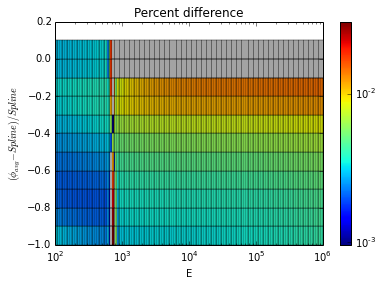

In [94]:
# Sanity check
# Plot the difference between the bin-averaged flux, and the spline evaluated at the middle of each bin

plt.figure()
plt.pcolor(XNEW,YNEW,Z_p, norm = colors.LogNorm(), edgecolors='k', linewidths=0.4)
plt.xscale('log')
plt.xlim(xmax=1000000)
plt.colorbar()

plt.xlabel("E")
plt.ylabel("$(\phi_{avg} - Spline)/Spline$")
plt.title("Percent difference")
plt.show()

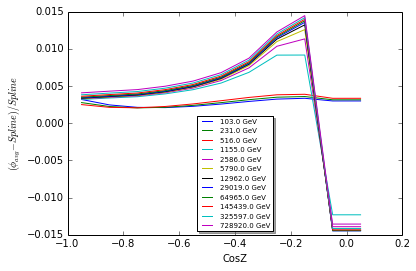

In [95]:
# Sanity check
# For given energies...

stepsize = 14
color_list = plt.cm.jet(np.linspace(0, 1, 12))
for i in np.arange(len(color_list)):
    plt.plot(yavg[:],Z_p[stepsize*i][:], label=str(np.around(xavg[stepsize*i]))+" GeV")

plt.xlabel("CosZ")
plt.ylabel("$(\phi_{avg} - Spline)/Spline$")   
legend = plt.legend(loc='lower center', shadow=True, fontsize='x-small')
plt.show()

In [96]:
# Now combine pi and K fluxes

N = 0.93
R_k = 1.15
combined_flux = N*(avg_flux_pi + R_k * avg_flux_k)

# Now compare to Chris' flux

ChrisFile = h5py.File("conventional_flux.h5","r")
Chris_int_flux = ChrisFile['/nu_mu/integrated_flux']

Chris_avg_flux = np.zeros(Chris_int_flux.shape)
a,b = Chris_avg_flux.shape

for i in np.arange(a):
    for j in np.arange(b):
        Chris_avg_flux[i][j] = Chris_int_flux[i][j]/ (2*np.pi*(xnew[i+1]-xnew[i])*(ynew[j+1]-ynew[j]))


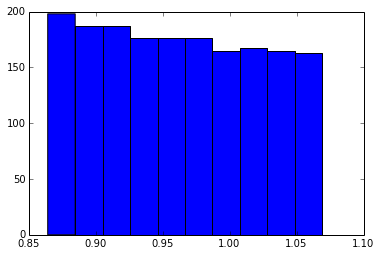

In [97]:
# Histogram of the ratio of my combined flux and Chris' bin-averaged flux
_=plt.hist(combined_flux[:cutoff_index+1,:].flatten()/Chris_avg_flux[:cutoff_index+1,:].flatten())


In [98]:
#_=plt.hist(combined_flux[:cutoff_index+1,:].flatten()/Chris_int_flux[:cutoff_index+1,:].flatten())
#plt.semilogy()

In [99]:
"""plt.figure()
plt.pcolor(XNEW[:cutoff_index+2,:],YNEW[:cutoff_index+2,:],avg_flux_pi[:cutoff_index+1,:], 
           norm = colors.LogNorm(), edgecolors='k', linewidths=0.3)

plt.xscale('log')
plt.colorbar()
plt.title("Averaged")
plt.show()"""

'plt.figure()\nplt.pcolor(XNEW[:cutoff_index+2,:],YNEW[:cutoff_index+2,:],avg_flux_pi[:cutoff_index+1,:], \n           norm = colors.LogNorm(), edgecolors=\'k\', linewidths=0.3)\n\nplt.xscale(\'log\')\nplt.colorbar()\nplt.title("Averaged")\nplt.show()'

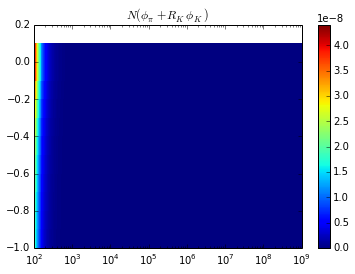

In [100]:
plt.figure()
plt.pcolor(XNEW,YNEW,combined_flux)
plt.xscale('log')
plt.colorbar()
plt.title("$N(\phi_\pi+R_K \phi_K)$")
plt.show()

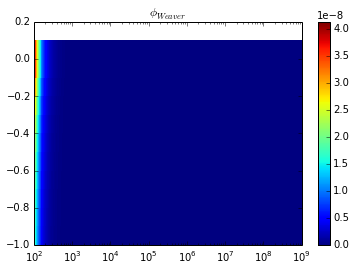

In [101]:
plt.figure()
plt.pcolor(XNEW,YNEW,Chris_avg_flux[:][:])
plt.xscale('log')
plt.colorbar()
plt.title("$\phi_{Weaver}$")
plt.show()

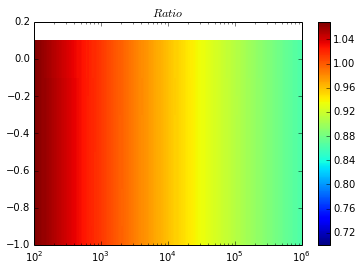

In [102]:
plt.figure()
plt.pcolor(XNEW,YNEW,combined_flux/Chris_avg_flux, vmin=.7)
plt.xscale('log')
plt.xlim(xmax=1000000)
plt.colorbar()
plt.title("$Ratio$")
plt.show()

In [103]:
#Check to see if the difference between my flux and CW's flux can be accounted for by the spectral index


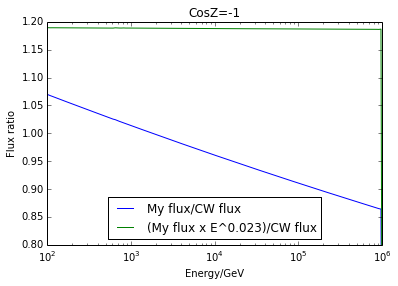

In [104]:
plt.plot(xavg[:],combined_flux[:,8]/Chris_avg_flux[:,8], label='My flux/CW flux')
plt.plot(xavg[:],combined_flux[:,8]*xavg[:]**0.023/Chris_avg_flux[:,8], label='(My flux x E^0.023)/CW flux')
plt.xscale('log')
plt.xlim(xmax=10**6)
plt.ylim(ymin=0.8)
plt.xlabel('Energy/GeV')
plt.ylabel('Flux ratio')
plt.title('CosZ=-1')
#plt.legend(loc = 'upper right', bbox_to_anchor = (1.8, 0.5))
plt.legend(loc='lower center')

In [105]:
# Now save to HDF5 file

In [106]:
ReadMeText = np.chararray((1,1), itemsize=1000)
ReadMeText[0] = "These fluxes are the bin-integrated initial numu (bar) fluxes originating from pions and kaons, separately, according to HondaGaisser models, before propagation through the Earth. I started with the fluxes come from the IC86 Sterile Neutrino Data release:  IC86SterileNeutrinoDataRelease/atmospheric_flux/initial/ I fit a spline to that data, and I used the energy and cosZ bins for which we have detector corrections. These fluxes are integrated over cosZ and energy bins, and over 2pi in azimuthal angle."

In [107]:
with h5py.File("Marjon_Int_HondaGaisser.h5","w") as hf:
    dset_pi_numu = hf.create_dataset('pi_nu_mu/integrated_flux', data=int_flux_pi, 
                                     compression="gzip", compression_opts=9, chunks=(280,11))
    dset_pi_numu.attrs['axis_0'] = ['Primary neutrino energy (GeV)']
    dset_pi_numu.attrs['axis_1'] = ['Cosine of primary neutrino zenith angle']
    dset_pi_numu.attrs['units'] = ['GeV^-1 cm^-2 s^-1 sr^-1']
    
    dset_pi_numu_bar = hf.create_dataset('pi_nu_mu_bar/integrated_flux', data=int_flux_pi_b, 
                                     compression="gzip", compression_opts=9, chunks=(280,11))
    dset_pi_numu_bar.attrs['axis_0'] = ['Primary neutrino energy (GeV)']
    dset_pi_numu_bar.attrs['axis_1'] = ['Cosine of primary neutrino zenith angle']
    dset_pi_numu_bar.attrs['units'] = ['GeV^-1 cm^-2 s^-1 sr^-1']

    dset_k_numu = hf.create_dataset('k_nu_mu/integrated_flux', data=int_flux_k, 
                                     compression="gzip", compression_opts=9, chunks=(280,11))
    dset_k_numu.attrs['axis_0'] = ['Primary neutrino energy (GeV)']
    dset_k_numu.attrs['axis_1'] = ['Cosine of primary neutrino zenith angle']
    dset_k_numu.attrs['units'] = ['GeV^-1 cm^-2 s^-1 sr^-1']
    
    dset_k_numu_bar = hf.create_dataset('k_nu_mu_bar/integrated_flux', data=int_flux_k_b, 
                                     compression="gzip", compression_opts=9, chunks=(280,11))
    dset_k_numu_bar.attrs['axis_0'] = ['Primary neutrino energy (GeV)']
    dset_k_numu_bar.attrs['axis_1'] = ['Cosine of primary neutrino zenith angle']
    dset_k_numu_bar.attrs['units'] = ['GeV^-1 cm^-2 s^-1 sr^-1']
    
    dset_energy_bin_edges = hf.create_dataset('bin_edges/energy_bin_edges', data=xnew)
    dset_cosz_bin_edges = hf.create_dataset('bin_edges/cosz_bin_edges', data=ynew)
    
    #dset_README = hf.create_dataset?
    dset_README = hf.create_dataset('README', data=ReadMeText)

In [108]:
# Now compare to Honda's flux
# I didn't finish this part....

In [109]:
def filter_lines(f, stride):
    for i, line in enumerate(f):
        if i%stride and (i-1)%stride:
            yield line

In [110]:
with open ("spl-nu-20-12-000.d") as f:
    HondaEnu_unshaped, HondaNuMu_unshaped, HondaNuMubar_unshaped = np.genfromtxt(filter_lines(f,103), 
                                                                                 usecols = (0,1,2), unpack = True)

In [111]:
HondaNuMu_SumA = np.zeros((101,20))
a, b, c, sum = 101, 20, 12, 0
for i in np.arange(a):                                   #loop over energies
    for j in np.arange(b):                               #loop over cosZ
        for k in np.arange(c):                           #loop over azimuth
            sum += HondaNuMu_unshaped[i+101*12*j+101*k]
            sum = sum/(10**4)                            #convert from m^-2 to cm^-2
#            sum = sum/(2*np.pi)                             #I don't know
        HondaNuMu_SumA[i][j] = sum
        sum = 0

In [112]:
array = np.arange(-1.0, 1.1, 0.1)
HondaCosZ = array[::-1]
HondaCosZ_avg = np.zeros(len(HondaCosZ)-1)

for i in np.arange(len(HondaCosZ_avg)):
    HondaCosZ_avg[i] = (HondaCosZ[i]+HondaCosZ[i+1])/2
print HondaCosZ_avg

[ 0.95  0.85  0.75  0.65  0.55  0.45  0.35  0.25  0.15  0.05 -0.05 -0.15
 -0.25 -0.35 -0.45 -0.55 -0.65 -0.75 -0.85 -0.95]


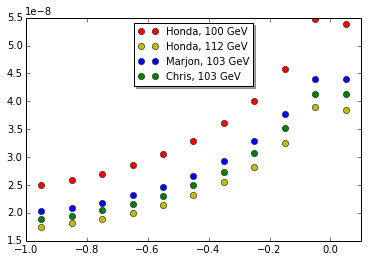

In [113]:
plt.plot(HondaCosZ_avg, HondaNuMu_SumA[60], 'ro', label ="Honda, 100 GeV")
plt.plot(HondaCosZ_avg, HondaNuMu_SumA[61], 'yo', label ="Honda, 112 GeV")
plt.plot(yavg, combined_flux[0,:], 'bo', label= "Marjon, 103 GeV")
plt.plot(yavg, Chris_avg_flux[0,:], 'go', label="Chris, 103 GeV")
plt.xlim(xmax=0.1)
legend = plt.legend(loc='upper center', shadow=True, fontsize='medium')

In [114]:
Hondax = HondaEnu_unshaped[0:101]
Honday = HondaCosZ_avg
Honday_flipped = Honday[::-1]

a,b = HondaNuMu_SumA.shape
HondaNuMu_SumA_flipped = np.zeros((a,b))

for i in np.arange(a):
    for j in np.arange(b):
        HondaNuMu_SumA_flipped[i][j] = HondaNuMu_SumA[i][b-1-j]
        

In [115]:
s_Honda = interpolate.RectBivariateSpline(Hondax,Honday_flipped,HondaNuMu_SumA_flipped)